# Titanic V2

In [65]:
# Who survived?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot
import graphviz
import pydotplus

1 - Chargement des données

In [66]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

2 - Visualisation des données brut

valeur manquente, difference entre mean et std (ou mean et min/max)

In [67]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


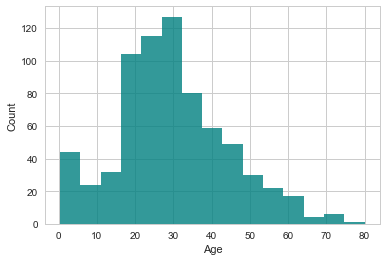

29.69911764705882


28.0

In [68]:
ax = train["Age"].hist(bins=15, color='teal', alpha=0.8)
ax.set(xlabel='Age', ylabel='Count')
plt.show()
print(train["Age"].mean())
train["Age"].median(skipna=True)

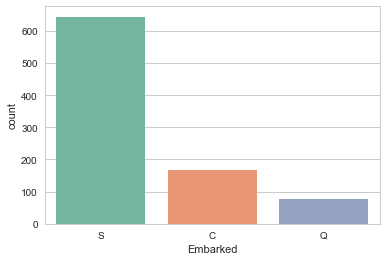

In [69]:
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='Embarked',data=train,palette='Set2')
plt.show() #Q=2, S=1, C=0

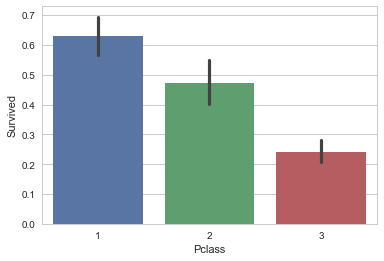

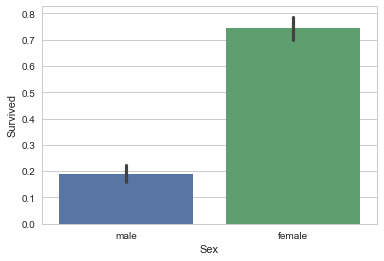

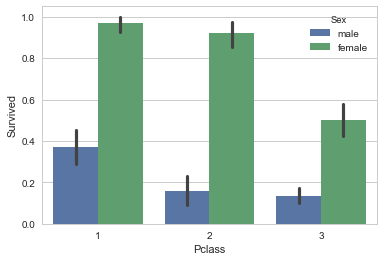

In [70]:
sns.barplot('Pclass', 'Survived', data=train)
plt.show()

sns.barplot('Sex', 'Survived', data=train)
plt.show()

sns.barplot('Pclass', 'Survived', hue='Sex', data=train)
plt.show()

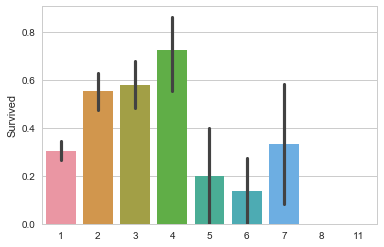

In [71]:
sns.barplot((train['SibSp'] + train['Parch'] + 1), train['Survived'])
plt.show()

3 - Prétraitement des données et Création de nouvelle variable

In [72]:
train.replace(to_replace=dict(female=1, male=0), inplace=True)
#train.replace(to_replace=dict(Q=2, S=1, C=0), inplace=True)
test.replace(to_replace=dict(female=1, male=0), inplace=True)

#creation de la variable FamilySize
def familySize(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    bins = [0,1,3, 4, 11]
    df['FamilySize'] = pd.cut(df['FamilySize'], bins, labels= [1,2,3,5])
    return df
    
def simplify_ages(df):
    df.Age = df.Age.fillna(df.Age.median())
    #df.Age = df.Age.fillna(-0.5) #on remplace les valeurs manquente par -0.5
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    #group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    group_names = [-1, 0, 5, 12, 18, 25, 35, 60]
    df.Age = pd.cut(df.Age, bins, labels=group_names)
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N') #on remplace les valeurs manquente par N
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(df.Fare.median())
    #df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    #group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    group_names = [-1, 1, 2, 3, 4]
    df.Fare = pd.cut(df.Fare, bins, labels=group_names)
    return df 
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Cabin', 'SibSp', 'Parch', 'Embarked'], axis=1)

def transform_features(df):
    df = familySize(df)
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = drop_features(df)
    return df

data_train = transform_features(train)
data_test = transform_features(test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize
0,1,0,3,0,18,1,2
1,2,1,1,1,35,4,2
2,3,1,3,1,25,1,1
3,4,1,1,1,25,4,2
4,5,0,3,0,25,2,1


  FamilySize  Survived
3          5  0.161290
0          1  0.303538
1          2  0.562738
2          3  0.724138


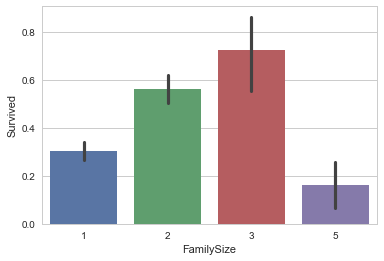

In [73]:
familySurvived = train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(['Survived'], ascending = True)
print(familySurvived)
sns.barplot(train['FamilySize'], train['Survived'])
plt.show()

4 - Split des données Train/Test

ici le jeu de test est celui de kaggle, nous ne connaissons pas les reponsses

In [74]:
y=data_train.Survived
x=data_train.drop(['Survived','PassengerId'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
x_train.head()

,Pclass,Sex,Age,Fare,FamilySize
445,1,0,0,4,2
650,3,0,25,1,1
172,3,1,0,2,2
450,2,0,35,3,3
314,2,0,35,3,2


5 - Entrainement  (descente de gradien, affichage erreur)

In [75]:
def entrainement():
    listEnt=[]
    listEnt.append(linear_model.LogisticRegression().fit(x_train, y_train))
    listEnt.append(GaussianNB().fit(x_train, y_train))
    listEnt.append(tree.DecisionTreeClassifier().fit(x_train, y_train))
    listEnt.append(KNeighborsClassifier().fit(x_train, y_train))
    listEnt.append(LinearSVC().fit(x_train, y_train))
    
    return listEnt

entr = entrainement()
entr

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 GaussianNB(priors=None),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_s

6 - Verification de la performance sur le jeu de donnée test

In [76]:
for i in entr:
    print(i.score(x_train, y_train))

0.797752808988764
0.7768860353130016
0.8731942215088283
0.8491171749598716
0.7431781701444623


In [77]:
for i in entr:
    print(i.score(x_test, y_test))

0.8059701492537313
0.7873134328358209
0.8208955223880597
0.8246268656716418
0.7761194029850746


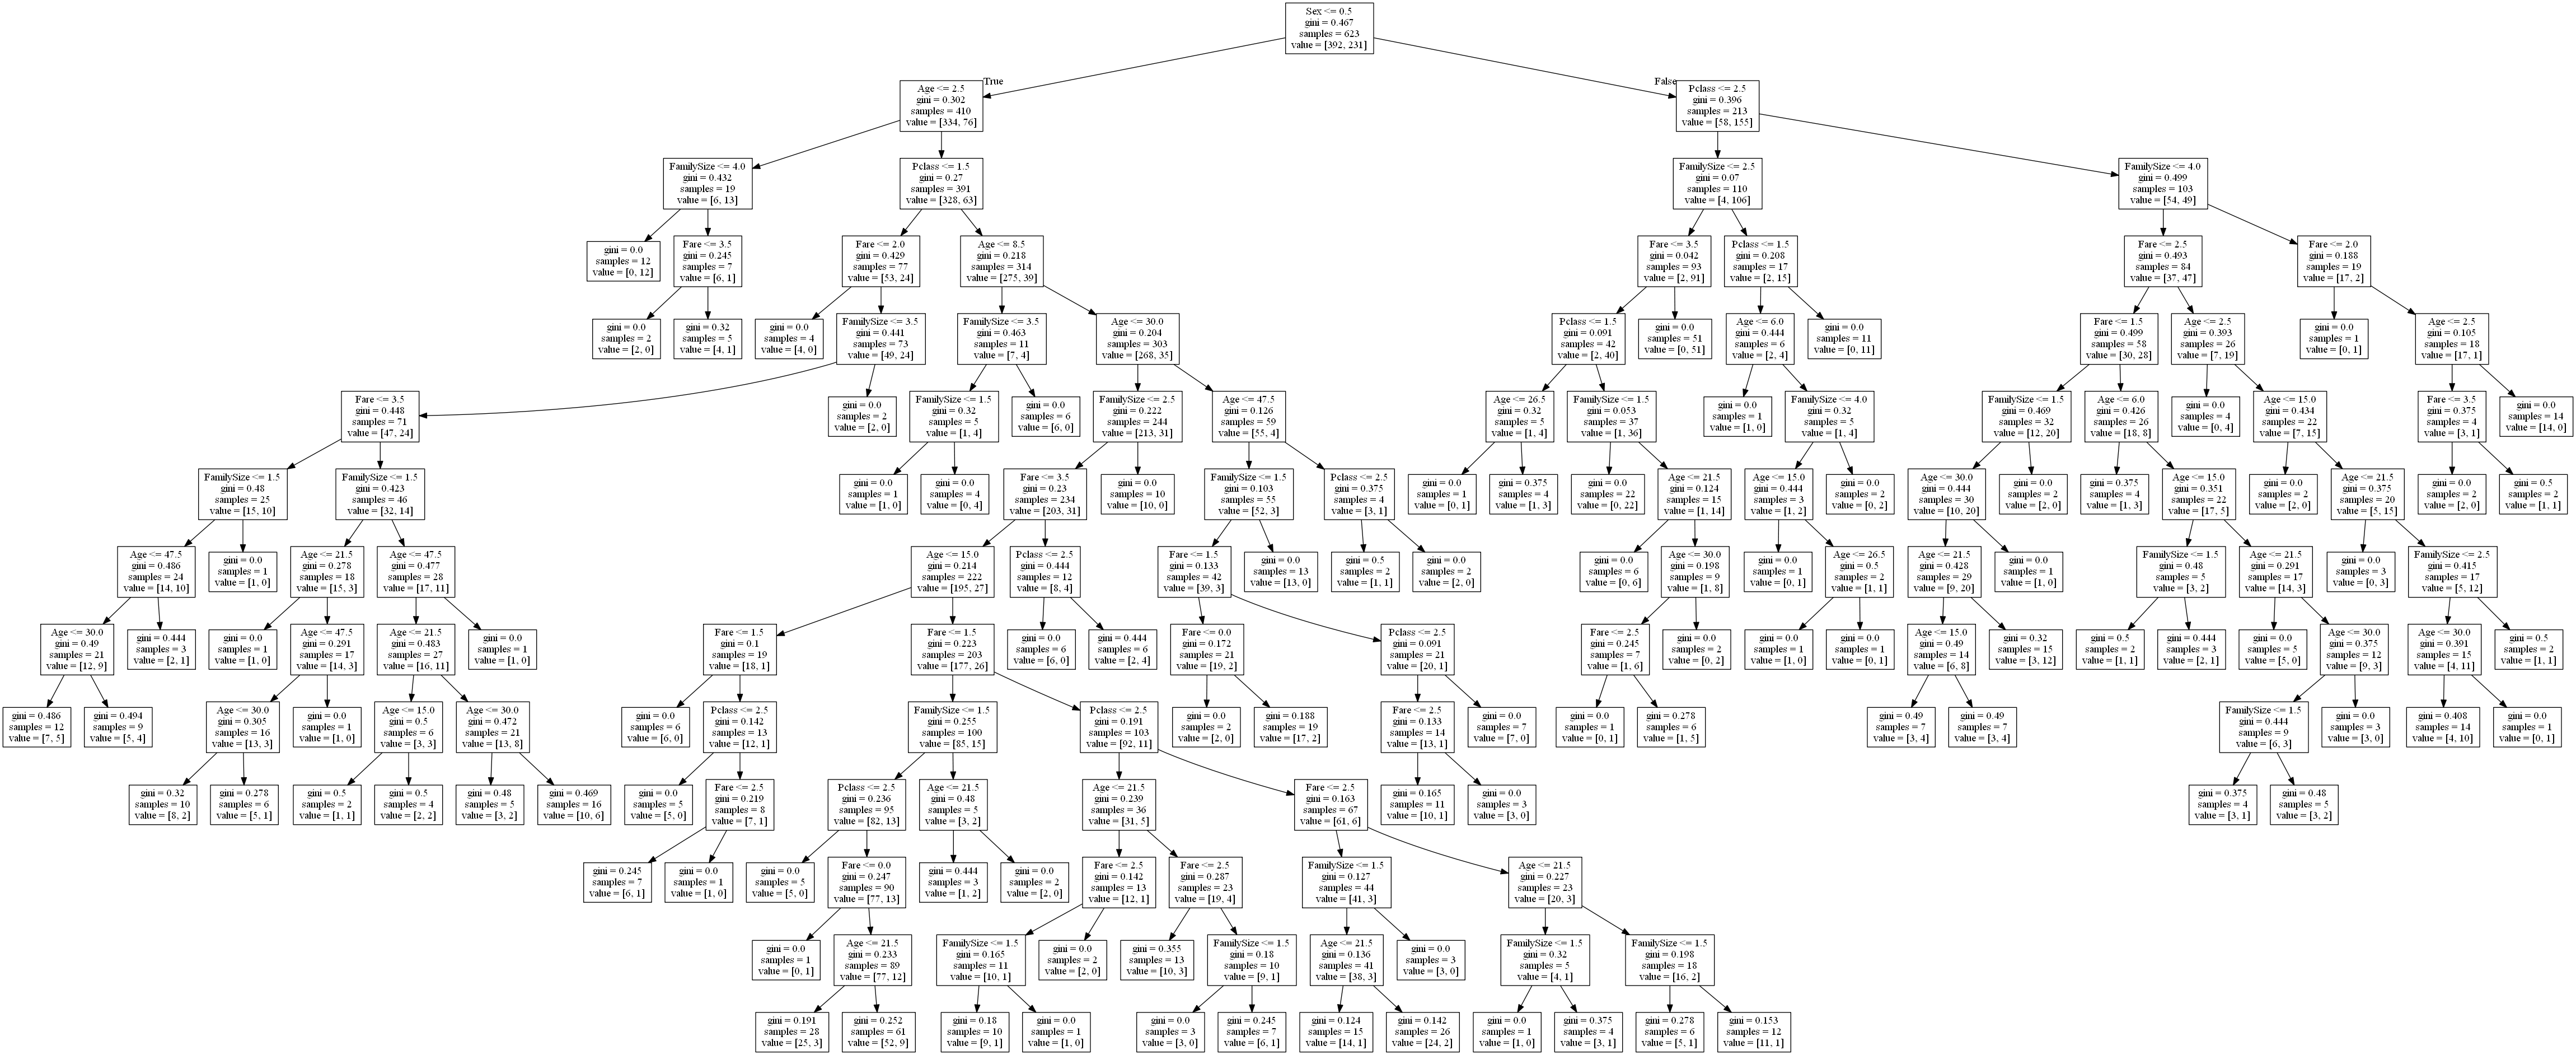

In [78]:
dot_data = StringIO()
tree.export_graphviz(entr[2], out_file=dot_data, feature_names = x_train.columns) #, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())